In [20]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



import os

import pandas as pd
import numpy as np

from tqdm import tqdm


import sentencepiece

import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

#rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Make the Training Data randomly ordered 
AND split it into a training and testing set

In [21]:
pre_dataset = pd.read_csv('combined_speeches.csv')

In [22]:
del pre_dataset['Unnamed: 0']

In [23]:
pre_dataset.head()

,0,Ideology
0,how are you donald well thank you lester and t...,1
1,well thank you are you a teacher yes i think t...,1
2,thank you very much chris and thanks to unlv f...,1
3,wow what a great way to begin and to all of yo...,1
4,thank you so much it is wonderful to be here a...,1


In [24]:
pre_dataset = pre_dataset.drop(pre_dataset.index[86:])

In [25]:
print(pre_dataset.count())

0           86
Ideology    86
dtype: int64


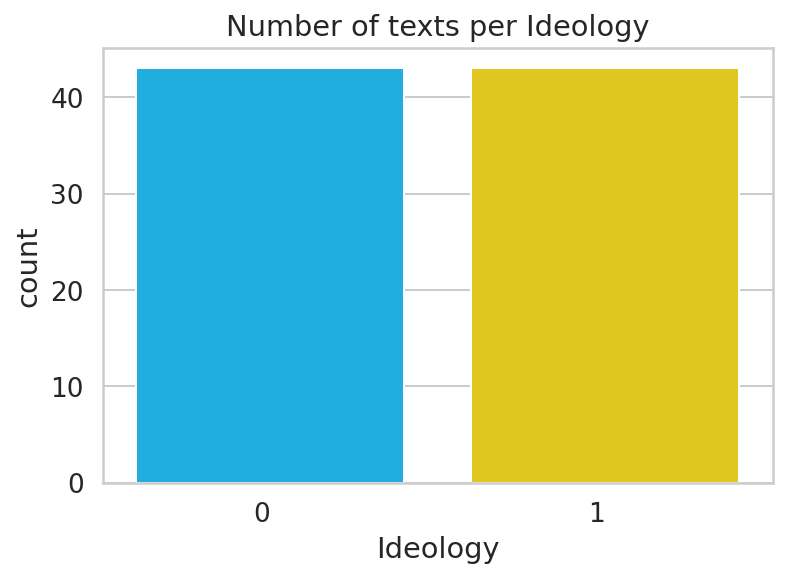

In [26]:
rand_dataset = pre_dataset.sample(n=86)

rand_dataset.head(20)

chart = sns.countplot(rand_dataset.Ideology, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per Ideology")
chart.set_xticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right');

In [27]:
speeches = []
ideology = []
for thing in rand_dataset.values:
    speeches.append(thing[0])
    ideology.append(thing[1])

In [28]:
vocab_size = 10000
embedding_dim = 32
max_length = 9120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 70

In [29]:
training_speeches = speeches[0:training_size]
testing_speeches = speeches[training_size:]
training_ideologies = ideology[0:training_size]
testing_ideologies = ideology[training_size:]

In [30]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_speeches)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_speeches)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_speeches)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [31]:
import numpy as np
training_padded = np.array(training_padded)
training_ideologies = np.array(training_ideologies)
testing_padded = np.array(testing_padded)
testing_ideologies = np.array(testing_ideologies)

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.LSTM(1),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 9120, 32)          320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 320,817
Trainable params: 320,817
Non-trainable params: 0
_________________________________________________________________


In [36]:
num_epochs =28
history = model.fit(training_padded, training_ideologies, epochs=num_epochs, validation_data=(testing_padded, testing_ideologies), verbose=2)

Epoch 1/28
3/3 - 0s - loss: 0.6923 - accuracy: 0.4857 - val_loss: 0.6917 - val_accuracy: 0.6875
Epoch 2/28
3/3 - 0s - loss: 0.6919 - accuracy: 0.5429 - val_loss: 0.6913 - val_accuracy: 0.6250
Epoch 3/28
3/3 - 0s - loss: 0.6914 - accuracy: 0.5857 - val_loss: 0.6910 - val_accuracy: 0.6875
Epoch 4/28
3/3 - 0s - loss: 0.6911 - accuracy: 0.6143 - val_loss: 0.6905 - val_accuracy: 0.5625
Epoch 5/28
3/3 - 0s - loss: 0.6906 - accuracy: 0.6286 - val_loss: 0.6903 - val_accuracy: 0.6875
Epoch 6/28
3/3 - 0s - loss: 0.6902 - accuracy: 0.7286 - val_loss: 0.6899 - val_accuracy: 0.7500
Epoch 7/28
3/3 - 0s - loss: 0.6897 - accuracy: 0.7286 - val_loss: 0.6895 - val_accuracy: 0.7500
Epoch 8/28
3/3 - 0s - loss: 0.6892 - accuracy: 0.7286 - val_loss: 0.6890 - val_accuracy: 0.8125
Epoch 9/28
3/3 - 0s - loss: 0.6887 - accuracy: 0.7429 - val_loss: 0.6884 - val_accuracy: 0.8125
Epoch 10/28
3/3 - 0s - loss: 0.6881 - accuracy: 0.7429 - val_loss: 0.6881 - val_accuracy: 0.7500
Epoch 11/28
3/3 - 0s - loss: 0.6875 - a

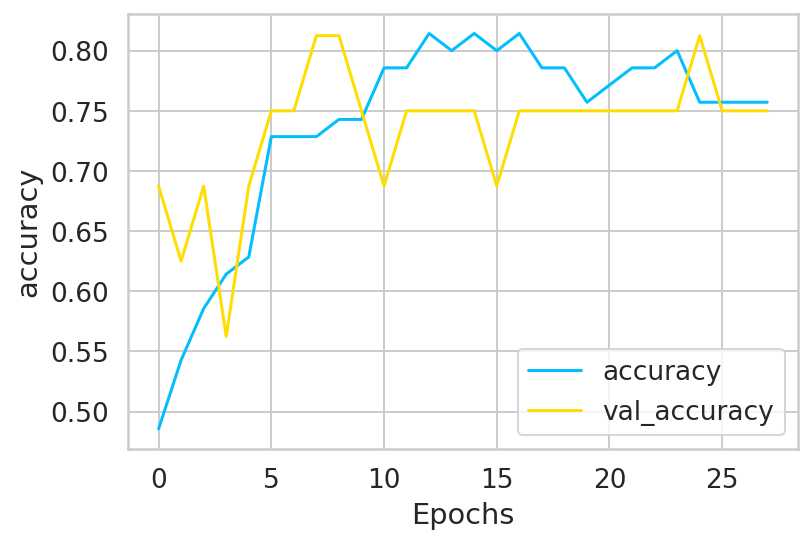

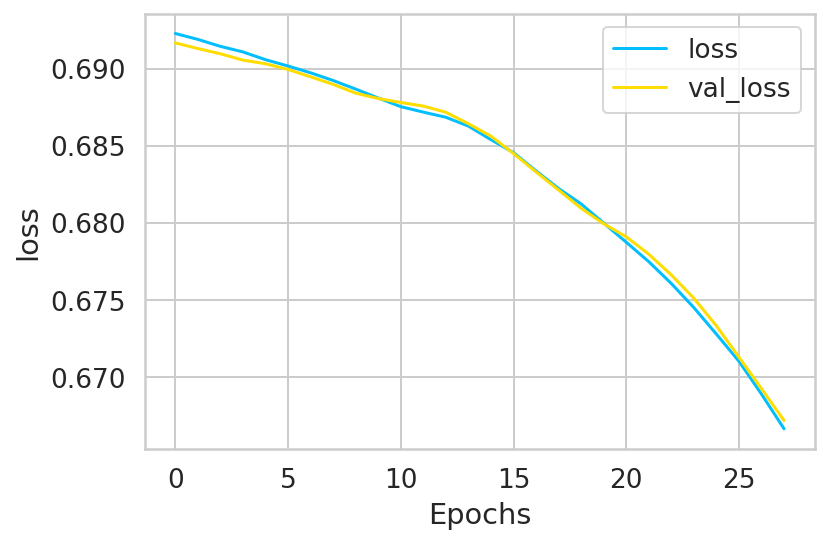

In [37]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [38]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 32)


In [42]:
i=0
training_predictions = []
for i in range(training_size):
    sentence = [training_speeches[i]]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    training_predictions.append(model.predict(padded))
    print(training_ideologies[i])
    print(model.predict(padded))
    print("\n")

0
[[0.46674457]]


1
[[0.52235556]]


0
[[0.46737805]]


1
[[0.4890468]]


1
[[0.5153033]]


0
[[0.47180894]]


1
[[0.50166976]]


1
[[0.49034956]]


1
[[0.49778813]]


0
[[0.47333908]]


0
[[0.46786433]]


0
[[0.46954525]]


0
[[0.46614182]]


0
[[0.46076554]]


0
[[0.46753195]]


0
[[0.4761136]]


1
[[0.523831]]


0
[[0.46526924]]


0
[[0.465584]]


0
[[0.49178466]]


1
[[0.5086514]]


1
[[0.51066184]]


1
[[0.50956196]]


1
[[0.49425682]]


1
[[0.47956464]]


0
[[0.4655992]]


1
[[0.5256023]]


1
[[0.5235768]]


1
[[0.5113399]]


1
[[0.5230159]]


0
[[0.5090483]]


0
[[0.5077477]]


1
[[0.47758213]]


1
[[0.52385277]]


1
[[0.52210534]]


1
[[0.514751]]


0
[[0.4664477]]


0
[[0.5010162]]


1
[[0.46918887]]


0
[[0.49546155]]


1
[[0.49465472]]


0
[[0.47760347]]


1
[[0.5247227]]


1
[[0.5172978]]


1
[[0.48348343]]


1
[[0.4918564]]


1
[[0.5026001]]


1
[[0.51603854]]


0
[[0.48939362]]


1
[[0.52397275]]


0
[[0.47980157]]


1
[[0.47929353]]


0
[[0.47204566]]


0
[[0.4663048]]


In [44]:
#random data to csv
rand_dataset.head()
rand_dataset.to_csv("rand_dataset.csv")

In [49]:
from tensorflow.keras.models import model_from_yaml
#code here from https://machinelearningmastery.com/save-load-keras-deep-learning-models/
'''
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk as yaml")
'''
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk as json")

Saved model to disk as json


In [48]:
#code here (still) from https://machinelearningmastery.com/save-load-keras-deep-learning-models/
'''
# later...

# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

'''

'\n# later...\n\n# load YAML and create model\nyaml_file = open(\'model.yaml\', \'r\')\nloaded_model_yaml = yaml_file.read()\nyaml_file.close()\nloaded_model = model_from_yaml(loaded_model_yaml)\n# load weights into new model\nloaded_model.load_weights("model.h5")\nprint("Loaded model from disk")\n\n'

In [ ]:
'''
the plan:
-toy with nn, test nn on the trump speeches you removed at the beginning DONE
-save nn IN PROGRESS
-pass training_predictions of nn as training_x
-pass training_ideologies as training_y
-toy with ml models
'''